# BRIEF SUMMARY

There is a large amount of data available related to professional basketball in the NBA. After the introduction of SportVU cameras in every stadium, we now have the ability to know exactly where all five offensive players and all five defensive players are at every moment of the game. We also know **where every shot is taken**. 


Sports analysts and data scientists are already studying where players shoot from. Check out Austin Clemens' great web app that helps you visually compare players' and teams' shot charts to the league average:
http://www.austinclemens.com/shotcharts/#teams
But most of these shot charts are visualizations of histograms or scatter plots of raw shooting data.


That doesn't initially sound bad, but a player's shots in a single season is only a sparse sampling of the true (or underlying) spatial probability distriubtion of that player's shooting habits.
To give you a sense how sparse the sampling is, let's consider the dimensions of half of the court (or that player's offensive zone): 50x47 feet. 
If we divide that area into 2x2 feet bins, we have about 580 bins. On average (of the top 300 players), the total number of shots taken in a season is just over 600. 
That means many bins are going to be rarely sampled if at all, giving inaccurate estimates of the probability distribution.

------------------------


That made me wonder:
* How predictive are these raw histograms?
* Can we **improve our predictive power** by constructing a **statistical model**?

As you may have guessed, I was able to develop a more predictive model. 
I found that a log Gaussian Cox process (LGCP) model had a drastically higher log-likelihood score of predicting shot locations from a testing dataset.
In short, the model smoothens the distriubtion by assuming that two nearby areas likely do not have vastly different shot probabilties.


I am also curious if we can take shot analysis to another level: 
* Are the common basketball tropes of shot locations (e.g. inside shot, shot from the high post, and corner three) **features** that naturally come out of the model shot distributions?
* Can we quantify how much a player shoots from these shot location categories and use them to group/compare players?

------------------

There is still a lot more to do, but I think this is a good foundation for analyzing shot behaviour.
But like most analyses, this also introduces more questions:
* Can we use these models to see if players are shooting from locations they are more effective from (i.e. higher field goal %)?
* How has a player's offensive game changed over the years? Did players who won Most Improved Player change their shot distribution, shot efficiency, both, or neither?
I also think this serves as an example for how machine learning principles can improve how we interpret sports data.

# LOADING and CLEANING DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import radar_plot
import sklearn.model_selection
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics


C:\Users\Geoff\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's load the data from the 2013-14 season that I downloaded from https://github.com/hwchase17/sportvu.

I will also remove any unwanted columns and add a column (the shooter's team).

In [2]:
# Load data and keep desired columns
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
full_DatFrame[:5]

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0
3,3,"Brown, Lorenzo",203485.0,3.6,19.0,0.0,10.0,0:23,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27.0,-15.0,274.0,1.0,0.0
4,0,"Cole, Norris",202708.0,3.7,0.0,1.0,-7.0,11:43,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24.0,-149.0,198.0,1.0,1.0


In [3]:
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])

# Add shooter's team column
teamID_dict = plot_court.out_teamsDict()
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']
df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)

## Discretizing the court for binning

Before I start analyzing the data, I must decide how I want to describe each player's spatial distribution of shots.

Instead of just analyzing the raw data, I wanted to use a model to estimate the underlying shot distribution that best describes the outcome. The raw data is sparse and there are a number of locations where a player did not take from. However, just because the player did not shoot from there over the course of the season does not mean that the probability of shooting from that location is zero. A model allows me to smoothen the shot distribution and have non-zero values for locations where no shots were taken (due to sparse sampling).

It is reasonable to model the spatial location of each shot attempt using an inhomogeneous Poisson point process. The Poisson point process is a commonly used statistical model of randomly located points in space. This will help us estimate the average number of expected shots (not an integer) from each location.

------------------------------------------------------------------------

To simplify the problem, I will grid up the court into small boxes and estimate the number of shots in the region defined by the box.

A finer grid is ideal. It will give me a better resolution of the shot distribution. However, a finer grid also requires more computation time to fit the model.

I settled on 25 horizontal rows (along x-axis) and 18 vertical columns (along y-axis). This corresponds to bins that are 2x2 feet areas on the court.

In [4]:
# Number of bins and range in each direction used to make the grid for analysis
bins, binRange = ([25,18], [[-250,250], [-47.5,312.5]])

hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(df.LOC_X, df.LOC_Y, 
                                                                    df.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=bins, 
                                                                    range=binRange)
# Creating the grid we will use for analysis
XX, YY = np.meshgrid(xedges, yedges)
binX_flat = XX.T[:-1,:-1].flatten()
binY_flat = YY.T[:-1,:-1].flatten()
binXY = np.column_stack((binX_flat.T, binY_flat.T))

## Creating training data for players

Let's create a list of the top 300 players in most shots taken during the 2013-14 season.

In [5]:
num_players = 300
top_players_shotNum = df.PLAYER_NAME.value_counts()[:num_players]
top_players_nameList = top_players_shotNum.index.tolist()

top_players_shotNum.describe()

count     300.000000
mean      623.156667
std       309.905259
min       193.000000
25%       356.000000
50%       579.000000
75%       817.750000
max      1677.000000
Name: PLAYER_NAME, dtype: float64

Now that I know which players I am including in my study, I want to create a training set for each player. 80% of each of these players' shots are added to the training set, and the other shots are added to a testing set.

We can use the testing set to verify our conclusions later.

In [6]:
train_df = {}
test_df = {}
randSeed = 348098
for i, player in enumerate(set(top_players_nameList)):  
    temp = df[df.PLAYER_NAME == player]
    train_df[player], test_df[player] = sklearn.model_selection.train_test_split(temp, test_size=0.2, random_state=randSeed)

    
player_shotHist_train = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = train_df[player]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=bins, 
                                                                        range=binRange)
    player_shotHist_train[player] = hist2d.flatten()
    
    
player_shotMadeHist_train = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = train_df[player][train_df[player].SHOT_MADE_FLAG == 1.0]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=bins, 
                                                                        range=binRange)
    player_shotMadeHist_train[player] = hist2d.flatten()

In [7]:
player_shotHist_test = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = test_df[player]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=bins, 
                                                                        range=binRange)
    player_shotHist_test[player] = hist2d.flatten()

## Unpredictive raw histograms


histN_v = Xn_v/np.sum(Xn_v)

plot_player_x2(player, histN_v, add_title='raw histogram')

The likelihood that we observe the data ($p(\mathbf{x_n}|z_0, \mathbf{z_n})$)

> ${\displaystyle p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \prod_{v=1}^V e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

> ${\displaystyle \ln p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \sum_{v=1}^V \left[ -\lambda_{n,v} + X_{n,v} \ln \lambda_{n,v} - \ln(X_{n,v}!) \right] }$

In [8]:
def ln_likelihood_rawHist(train_hist, test_hist):
    def ln_factorial(n):
        temp = scipy.misc.factorial(n)
        return np.log(temp)
    
    part1 = -train_hist
    part2 = test_hist * np.log(train_hist)
    part3 = -ln_factorial(test_hist)
    return np.sum(part1 + part2 + part3)

# LOG-GAUSSIAN COX PROCESS (LGCP) MODEL

## Theory behind the model

As mentioned previously, the spatial location of each shot attempt is treated as an event drawn from an **inhomogeneous Poisson point process**. 

For each player ($n$), I need to infer the expected number of shots ($\lambda_{n,v}$) taken from each grid point ($v$) on the discretized court. From that, we can get each player's shot profile ($\mathbf{\lambda_n} = [\lambda_{n,1} \dots \lambda_{n,V}]^T$), where $V$ is the number of grid points.

Since we don't know $\mathbf{\lambda_n}$, we will estimate it using **likelihood-maximization**. 

------------------------------------------

Note: We could use Markov chain Monte Carlo (MCMC) approach to take full advantage of this Bayesian inference approach. This would give us the level of certainty in $\mathbf{\lambda_n}$ for each player (not just the best fit).
This is something I might come back to later, but likelihood maximization is a good start.

------------------------------

Let's first start by defining some variables, how we obtain them, and how we will use them.

The data we imported and cleaned gives us a count of the number of shots ($X_{n,v}$) in each bin ($v$) for each player ($n$). This player data can be summarized by a flattened 2-dimensional histogram: $\mathbf{x_n} = [X_{n,1} \dots X_{n,V}]^T$.

For a given player shot profile ($\mathbf{\lambda_n}$), the likelihood we see the observed data ($\mathbf{x_n}$) follows a Poisson process:

> ${\displaystyle p(\mathbf{x_n}|\mathbf{\lambda_n}) = \prod_{v=1}^V p(X_{n,v}|\lambda_{n,v}) }$

> ${\displaystyle p(X_{n,v}|\lambda_{n,v}) = e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

where $p(X_{n,v}|\lambda_{n,v})$ is the probability that $X_{n,v}$ shots are taken in area $v$ given that the expected number is $\lambda_{n,v}$. The above equation assumes that each shot is independent.

-----------------------------------------

However, what we are really interested in is the shot profile that maximizes the likelihood of seeing the data. To do this, we turn to Bayes' theorem.

The likelihood of a given shot profile ($\mathbf{\lambda_n}$) explaining the observed data is

> ${\displaystyle p(\mathbf{\lambda_n}|\mathbf{x_n}) \propto p(\mathbf{x_n}|\mathbf{\lambda_n}) p(\mathbf{\lambda_n}) }$

The $\mathbf{\lambda_n}$ that maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$ will gives us the best estimate of each player's shot profile. I already showed how to compute $p(\mathbf{x_n}|\mathbf{\lambda_n})$, but how to compute $p(\mathbf{\lambda_n})$ is less clear.

--------------------------------------------------------

The prior ($p(\mathbf{\lambda_n})$) describes how confident I am in what $\mathbf{\lambda_n}$ should be.

We could set $p(\mathbf{\lambda_n})$ to a constant, which says all values of $\mathbf{\lambda_n}$ are equally likely. For this case, the $\mathbf{\lambda_n}$ that maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$ is simply $\mathbf{\lambda_n} = \mathbf{x_n}$. This is the frequentist approach which is the same as using the raw data instead of fitting a model. This has two undesired properties:

1. $\lambda_{n,v}=0$ in areas where a player didn't shoot from. But just because a player didn't shoot from a certain bin during the season doesn't mean the probability of him shooting from there is zero.

2. $\lambda_{n,v}$ and $\lambda_{n,v'}$ are not correlated, even if bins $v$ and $v'$ are nearby. I don't expect that a player's shooting behavior changes drastically just a few feet away. 

----------------------------------------------------

To solve both issues, we define $p(\mathbf{\lambda_n})$ as

> ${\displaystyle p(\mathbf{\lambda_n}) = p(\mathbf{z_n}) = \mathcal{N}(\mathbf{z_n}|0,\mathbf{K}) }$

> ${\displaystyle \mathbf{\lambda_n} = \exp(z_0 + \mathbf{z_n}) }$

where $z_0$ is a bias term and $\mathcal{N}(\mathbf{z_n}|0,\mathbf{K})$ is a normal distribution over a field variable $\mathbf{z_n}$ with a zero mean and a covariance $\mathbf{K}$. 

*A Jacobian is not needed for the change of variables in the probability from $p(\mathbf{\lambda_n})$ to $p(\mathbf{z_n})$ because they are discrete probabilities.

The covariance matrix ($\mathbf{K}$) captures the correlations between neighboring bins. The closer the bins are, the larger the pair correlation. A simple way to capture this is to use an isotropic function to describe the correlations so they are only a function of the distance between bins (and not whether the bins are left, right, etc. of each other). In this work, $\mathbf{K}$ has elements $K_{i,j}$, where

> ${\displaystyle K_{i,j} = \sigma^2 \exp \left( - \frac{d_{i,j}^2}{2 \phi^2} \right) }$

$d_{i,j}$ is the distance between bins $i$ and $j$, $\phi$ is a length scale, and $\sigma^2$ is the marginal variation. Since $d_{i,j} = d_{j,i}$, $\mathbf{K}$ is a symmetric matrix.

As mentioned previously, the correlation matrix makes $\lambda_{n,v}$ vary smoothly. Bins where a player didn't take shots from will have estimates that are similar to neighboring bins.

-------------------------------------------------


In [9]:
dist_matrix = scipy.spatial.distance_matrix(binXY, binXY)

def cov_func(dist_matrix, sigma2, phi2):
    return sigma2 * np.exp( -(dist_matrix**2) / (2 * phi2) )

I use a large $\sigma^2$ to show that we are not very certain about our inital guess of $z_{n,v} = 0$ for all bins $v$.

I also set $\phi$ to be 2.5 feet. I just chose this value because it seemed reasonable.

In [10]:
sigma2 = 1e3
phi2 = 40.**2

cov_K = cov_func(dist_matrix, sigma2, phi2)

# np.linalg.det under/overflows for very small/large values of det, so slogdet is more robust
sign, logdet_cov_K = np.linalg.slogdet(cov_K)
det_cov_K = sign * np.exp(logdet_cov_K)

inv_cov_K = np.linalg.inv(cov_K)
nbins = np.prod(bins)

print(sign, logdet_cov_K, det_cov_K)

1.0 -543.072458154 1.40161310704e-236


## Putting the model into Python

The $\mathbf{\lambda_n}$ that maximizes $\ln p(\mathbf{\lambda_n}|\mathbf{x_n})$ also maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$. This is convenient because maximizing $\ln [p(\mathbf{\lambda_n}|\mathbf{x_n}) ]$ is computationally cheaper.

So we define the following functions:

---------

The first is the logarithm of the prior distribution ($\ln p(\mathbf{\lambda_n})$)

> ${\displaystyle p(\mathbf{\lambda_n}) = \frac{1}{\sqrt{\det(2 \pi \mathbf{K})}} \exp \left( -\frac{1}{2} \mathbf{z_n}^T \mathbf{K^{-1}} \mathbf{z_n} \right) }$

In [11]:
def ln_prior(nbins, zn_v, logdet_cov_K, inv_cov_K):
    part1 = - (nbins/2.) * np.log(2 * np.pi) - (0.5 * logdet_cov_K)
    part2 = -0.5 * np.dot(zn_v, np.dot(inv_cov_K, zn_v))
    return part1 + part2

Then we define the player shot profile ($\mathbf{\lambda_n}$) and how it depends on the field variables ($z_0$ and $\mathbf{z_n}$).

> $\mathbf{\lambda_n} = \exp(z_0 + \mathbf{z_n})$

In [12]:
def lambdaN_func(z0, zn_v):
    return np.exp(z0 + zn_v)

def ln_lambdaN_func(z0, zn_v):
    return z0 + zn_v

Then we define the likelihood that we observe the data ($p(\mathbf{x_n}|z_0, \mathbf{z_n})$)

> ${\displaystyle p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \prod_{v=1}^V e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

> ${\displaystyle \ln p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \sum_{v=1}^V \left[ -\lambda_{n,v} + X_{n,v} \ln \lambda_{n,v} - \ln(X_{n,v}!) \right] }$

In [13]:
def ln_factorial(n):
    temp = scipy.misc.factorial(n)
    return np.log(temp)

def ln_likelihood(z0, zn_v, Xn_v):
    part1 = -lambdaN_func(z0, zn_v)
    part2 = Xn_v * ln_lambdaN_func(z0, zn_v)
    part3 = -ln_factorial(Xn_v)
    return np.sum(part1 + part2 + part3)

Finally, the posterior probability ($p(\mathbf{\lambda_n}|\mathbf{x_n})$) is

> $p(\mathbf{\lambda_n}|\mathbf{x_n}) = \mathrm{const} \times p(\mathbf{x_n}|\mathbf{\lambda_n}) p(\mathbf{\lambda_n})$

> $\ln p(\mathbf{\lambda_n}|\mathbf{x_n}) = \ln(\mathrm{const}) + \ln p(\mathbf{x_n}|\mathbf{\lambda_n}) + \ln p(\mathbf{\lambda_n})$

In [14]:
def ln_postprob(z, Xn_v, logdet_cov_K, inv_cov_K, nbins):
    z0 = z[0]
    zn_v = z[1:]
    return ln_prior(nbins, zn_v, logdet_cov_K, inv_cov_K) + ln_likelihood(z0, zn_v, Xn_v)

We then normalize $\mathbf{\lambda_n}$ such that $\sum_{v=1}^{V} \bar{\lambda}_{n,v} = 1$

> ${\displaystyle \mathbf{\bar{\lambda}_n} = \frac{ \mathbf{\lambda_n} }{ \sum_{v=1}^{V} \lambda_{n,v} } }$

To overlay the player's shot profile over the court, I define the following function:

In [15]:
def plot_player_normLambda(player, norm_lambdaN_v, vmax=None, add_title=''):
    LAMBDA_v = np.reshape(norm_lambdaN_v, bins)
    ##########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.imshow(LAMBDA_v.T, cmap=plt.cm.magma_r, alpha=.85, vmax=vmax,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: LGCP %s'%(player, add_title), fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_player_Xn(player, Xn_v, vmax=None, add_title=''):
    Xn_2d = np.reshape(Xn_v, bins)
    #########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.imshow(Xn_2d.T, cmap=plt.cm.magma_r, alpha=.85, vmax=vmax,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: histogram of data %s'%(player, add_title), fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Testing the model on a player

To verify that our model is working in Python, we will apply it to one of the star players in the NBA: Kevin Durant.

------ 72.61306095123291 seconds ------


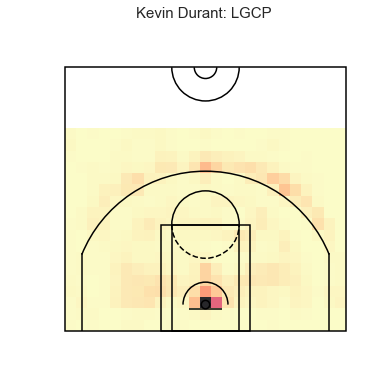

In [16]:
import time
start_time = time.time()

player = 'Kevin Durant'
####################################################
Xn_v = player_shotHist_train[player]

z0_guess = np.log(np.mean(Xn_v))
zn_v_guess = 0. * Xn_v
z_guess = np.append(z0_guess, zn_v_guess)

neg_logLike = lambda *args: -ln_postprob(*args)
result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                 args=(Xn_v, logdet_cov_K, inv_cov_K, nbins))
z_MaxLike = result["x"]
z0_MaxLike = z_MaxLike[0]
zn_MaxLike = z_MaxLike[1:]
lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)

print("------ %s seconds ------" %(time.time() - start_time))
plot_player_normLambda(player, norm_lambdaN_v, vmax=None)

That doesn't look like much. That's because Kevin Durant shoots the majority of his shots near the basket (3 of 450 historgam bins). This isn't that suprising because players try to shoot from there because it is generally a lot easier to successfully score from there.

This makes the other features harder to see because the probability of shooting from places further from the basket is relatively small. Therefore, it is easier to see the spatial structure if we put a lower upper bound for our colorbar. 

You can see what I mean in the figures below.

In [17]:
import matplotlib.colors as colors

def plot_player_x2(player, norm_lambdaN_v, add_title=''):
    LAMBDA_v = np.reshape(norm_lambdaN_v, bins)
    ##########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.figure(figsize=(13,5))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        if (i == 0):
            vmax = None
            plt.imshow(np.ma.masked_where(LAMBDA_v.T == 0, LAMBDA_v.T), cmap=plt.cm.magma_r, alpha=.85, extent=extent)
        else:
            vmax = 0.02
            plt.imshow(LAMBDA_v.T, cmap=plt.cm.magma_r, 
                       norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),
                       alpha=.85, extent=extent)
        
        #plt.imshow(LAMBDA_v.T, cmap=plt.cm.magma_r, alpha=.85, vmax=vmax, extent=extent)
        plot_court.draw_court(outer_lines=True, lw=1.5)

        plt.xlim(-300,300)
        plt.ylim(-100,500)
        if (i == 0):
            plt.title('%s: %s'%(player, add_title), fontsize=15)
        else:
            plt.title('%s: %s \n emphasizing shots away from basket'%(player, add_title), fontsize=15)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

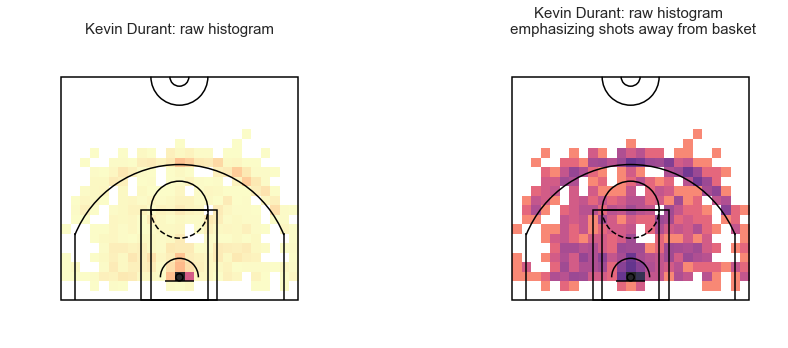

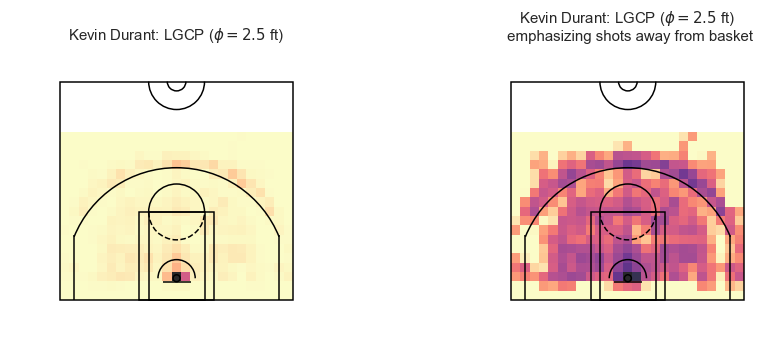

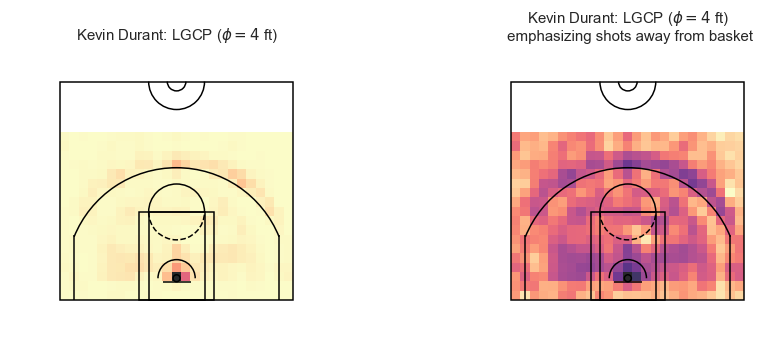

In [18]:
histN_v = Xn_v/np.sum(Xn_v)
norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))

plot_player_x2(player, histN_v, add_title='raw histogram')
plot_player_x2(player, norm_lambdaN_v_smallPhi, add_title=r'LGCP ($\phi=2.5$ ft)')
plot_player_x2(player, norm_lambdaN_v, add_title=r'LGCP ($\phi=4$ ft)')

From the above graphics, we can also see what happens when we change $\phi$. 

As mentioned previously, $\phi$ describes the characteristic correlation length scale. **Increasing $\phi$ means a player's shot shot probability is similar to a larger surrounding area.** In other words, increasing $\phi$ smooths the distribution more.

But which $\phi$ should we use? 
I propose looking at how predictive each model is. In other words, we want to see what model that was generated using training data has the highest likelihood to reproduce the testing data.
We have 3 situations to test out:
* raw histogram from the training set
* LGCP model with a small $\phi$ ($\phi=2.5$ ft) from the training set
* LGCP model with a large $\phi$ ($\phi=4.0$ ft) from the training set

## Does the smoothed distribution from LGCP improve predictions of testing data?

Remember, the likelihood that we observe the data  is $p(\mathbf{x_n}|z_0, \mathbf{z_n})$

> ${\displaystyle p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \prod_{v=1}^V e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

> ${\displaystyle \ln p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \sum_{v=1}^V \left[ -\lambda_{n,v} + X_{n,v} \ln \lambda_{n,v} - \ln(X_{n,v}!) \right] }$

In [19]:
def ln_factorial(n):
    temp = scipy.misc.factorial(n)
    return np.log(temp)

def ln_likelihood_givenLambda(lamdan_v, Xn_v):
    part1 = -lamdan_v
    part2 = Xn_v * np.log(lamdan_v)
    part3 = -ln_factorial(lamdan_v)
    return np.sum(part1 + part2 + part3)

Here is an example case for a specific player:

In [20]:
player = 'Caron Butler'
##########################
Xn_v = player_shotHist_test[player]
num_shots = np.sum(Xn_v)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~
norm_lambdaN_v_rawDat = player_shotHist_train[player]
norm_lambdaN_v_rawDat = norm_lambdaN_v_rawDat/np.sum(norm_lambdaN_v_rawDat)

norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))
norm_lambdaN_v_largePhi = np.loadtxt('player2014_lambda_new_seed546682/norm_lambda_%s.txt'%(player))

print(player)
print('no. of shots = ', int(num_shots))
############################################################

print('Log likelihood, reference (directly using test data) = ', ln_likelihood_givenLambda(Xn_v+1e-10, Xn_v))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ln_likelihood_rawDat = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_rawDat+1e-10, Xn_v)
print('Log likelihood, raw training data = ', ln_likelihood_rawDat)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ln_likelihood_LGCP_smallPhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_smallPhi, Xn_v)
print('Log likelihood, LGCP (phi=2.5 ft) = ', ln_likelihood_LGCP_smallPhi)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ln_likelihood_LGCP_largePhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_largePhi, Xn_v)
print('Log likelihood, LGCP (phi=4 ft) = ', ln_likelihood_LGCP_largePhi)

Caron Butler
no. of shots =  106
Log likelihood, reference (directly using test data) =  -89.8877158303
Log likelihood, raw training data =  -680.108071962
Log likelihood, LGCP (phi=2.5 ft) =  -198.858518864
Log likelihood, LGCP (phi=4 ft) =  -171.259741372


This is unexpected. Based on these results, $\phi=2.5$ ft out-performed $\phi=4.0$ ft. I would have thought the spatially smoother distribution would be a better representation of the underlying distribution that governs spatial shot frequency. But that doesn't seem to be the case. 

One possible reason for this is the unusally high shot frequencies near half court (very far from the basket). I need to further investigate why this is happening, but it does seem to be a weird artifact. 

Maybe if I used a finer grid the distributions would look a lot smoother and avoid the weird relatively large shot frequencies near half court. However, that would also greatly increase the computational cost. This is another thing to play around with later.

I tried this analysis on a number of players and saw that the **smaller $\phi=2.5$ ft consistently resulted in a higher likelihood**.

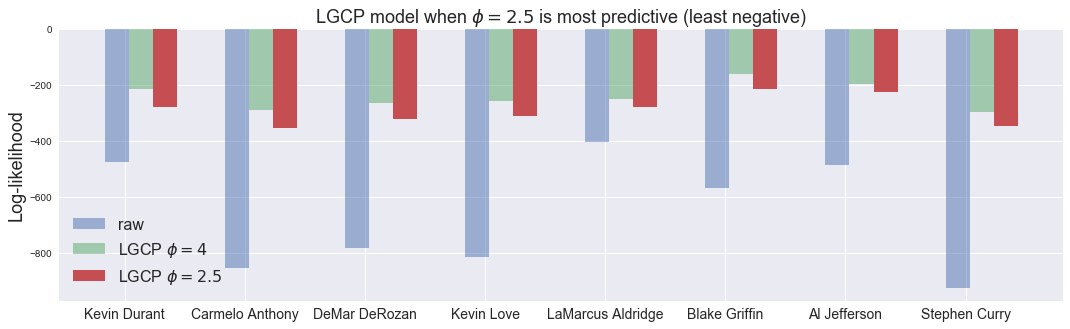

In [21]:
# Show the top 8 players
N = 8

rawDat_vec = []
LGCP_smallPhi_vec = []
LGCP_largePhi_vec = []
for i in range(N):
    player = top_players_nameList[i]
    Xn_v = player_shotHist_test[player]
    num_shots = np.sum(Xn_v)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~
    norm_lambdaN_v_rawDat = player_shotHist_train[player]
    norm_lambdaN_v_rawDat = norm_lambdaN_v_rawDat/np.sum(norm_lambdaN_v_rawDat)

    norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))
    norm_lambdaN_v_largePhi = np.loadtxt('player2014_lambda_new_seed546682/norm_lambda_%s.txt'%(player))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ln_likelihood_rawDat = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_rawDat+1e-10, Xn_v)
    ln_likelihood_LGCP_smallPhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_smallPhi, Xn_v)
    ln_likelihood_LGCP_largePhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_largePhi, Xn_v)
    
    rawDat_vec.append(ln_likelihood_rawDat)
    LGCP_smallPhi_vec.append(ln_likelihood_LGCP_smallPhi)
    LGCP_largePhi_vec.append(ln_likelihood_LGCP_largePhi)
    
ind = 2*np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18,5)

rects1 = ax.bar(ind, rawDat_vec, width, alpha=0.5)
rects2 = ax.bar(ind + width, LGCP_largePhi_vec, width, alpha=0.5)
rects3 = ax.bar(ind + 2*width, LGCP_smallPhi_vec, width)

# add some text for labels, title and axes ticks
ax.set_ylabel('Log-likelihood', fontsize=18)
ax.set_title('LGCP model when $\phi=2.5$ is most predictive (least negative)', fontsize=18)
ax.set_xticks(ind + width / 3)
ax.set_xticklabels(top_players_nameList[:N], fontsize=14)

ax.legend((rects1[0], rects2[0],rects3[0]), ('raw', r'LGCP $\phi=4$', r'LGCP $\phi=2.5$'), fontsize=16)

plt.show()

I could try other values of $\phi$, but for now I will exclusively used $\phi=2.5$.

# EXTRACTING the COMPONENTS of PLAYER PROFILES

## Brief overview of Non-negative Matrix Factorization (NMF)

Now that we have 300 player shot profiles, I thought it would be interesting to describe each player's shot profile as a linear combination of different components. This would help me simply but quantitatively describe and compare different players. 

This kind of dimensionality reduction is often done using principle component analysis (PCA). However, PCA would allow weights and elements of the components to be negative. Non-negative matrix factorization does something similar, but it also ensures that all weights and values of the components are zero or positive. This makes the components easy to interpret.

You probably noticed that computing $\mathbf{\lambda_n}$ for each player takes some time, so I ran the results for the top 300 players in shots taken and saved it in the "player2013_lambda_seed348098" directory.

We then store it in the matrix $\mathbf{\Lambda} = [\mathbf{\bar{\lambda}_1} \dots \mathbf{\bar{\lambda}_{100}}]^T$.

In [22]:
LL = np.zeros((num_players,np.prod(bins)))

randSeed = 348098
for i, player in enumerate(top_players_nameList):
    try:
        norm_lambdaN_v = np.loadtxt('player2013_lambda_seed%d/norm_lambda_%s.txt'%(randSeed, player))
    except:
        print('================================================')
        start_time = time.time()
        
        Xn_v = player_shotHist_train[player]
        z0_guess = np.log(np.mean(Xn_v))
        zn_v_guess = np.zeros(len(Xn_v))
        z_guess = np.append(z0_guess, zn_v_guess)
    
        neg_logLike = lambda *args: -ln_postprob(*args)
        result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                         args=(Xn_v, logdet_cov_K, inv_cov_K, nbins))
        z_MaxLike = result["x"]
        z0_MaxLike = z_MaxLike[0]
        zn_MaxLike = z_MaxLike[1:]
        lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
        norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
    
        print("------ %s seconds ------" %(time.time() - start_time))
        print(player)
        np.savetxt('player2013_lambda_seed%d/norm_lambda_%s.txt'%(randSeed, player), norm_lambdaN_v)
    LL[i,:] = norm_lambdaN_v[:]

I then I compute the weights ($\mathbf{W}$) and components ($\mathbf{H}$) matrices that approximate $\mathbf{\Lambda}$: 

> $\mathbf{\Lambda} \approx \mathbf{W} \mathbf{H}$

In [23]:
print(sklearn.__version__)

0.19.0


In [24]:
def plot_featuresH(H, n_comp, xedges, yedges, bins, figsize=(20,5), basis_names = None):
    plt.figure(figsize=figsize)
    if basis_names is None:
        basis_names = ['Basis vector %d'%(i) for i in range(n_comp)]
    for i in range(n_comp):
        plt.subplot(2, n_comp/2, i+1)

        extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

        plt.imshow(H[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.magma_r, alpha=.85,
                   extent=extent)
        plot_court.draw_court(outer_lines=True, lw=1.)

        plt.xlim(-300,300)
        plt.ylim(-100,500)
        plt.title(basis_names[i], fontsize=15)
        plt.axis('off')
    plt.show()

Let's see what happens when we vary the number of features (or components).

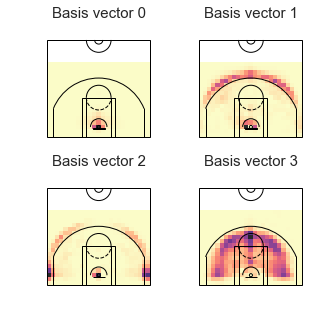

In [25]:
n_comp = 4
model = NMF(n_components=n_comp, init='nndsvda', max_iter=8000, tol=1e-7,
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W_4 = model.fit_transform(LL)
H_4 = model.components_   

plot_featuresH(H_4, n_comp, xedges, yedges, bins, figsize=(5,5))

That's awesome. We see that my algorithm **learned** 4 distinct shot features that an NBA analyst may talk about:
* **Basis 0**: very close-range shots
* **Basis 1**: straightaway/wing threes + very close-range shots
* **Basis 2**: corner/wing threes + very close-range shots
* **Basis 3**: mid-range + close shots
The most amazing part is that the model **learned these commonly known features without us explicitly telling it**.

Ideally, these feautes would be more spatially sparse and features would be localized to one general area of the court. 
For example, it would be nice if Basis 1 did not have very close-range shots in that feature vector, so the weights of that feature would just mean how frequently the player shot straightaway/wing threes.

But there could be an upside.
Maybe this means that players who are shooting these threes also shoot from those locations.
For those who are familiar with basketball, this isn't that suprising.
Defenders often "close-out hard" to good shooters behind the three point line, and the shooters can take the opportunity to drive to the basket and shoot a layup very close to the basket.
This isn't directly supported by this data analysis, so I would need to look into this later to see if the data can reveal these things.

It is also possible that we just need to add more features. So, let's try that.


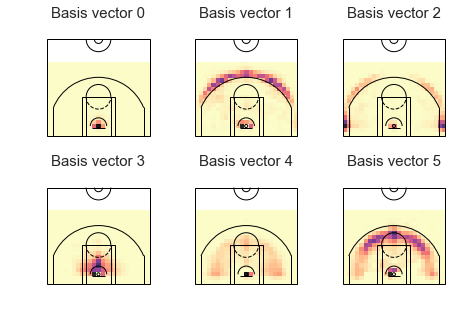

In [26]:
n_comp = 6
model = NMF(n_components=n_comp, init='nndsvda', max_iter=8000, tol=1e-7,
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W_6 = model.fit_transform(LL)
H_6 = model.components_   

plot_featuresH(H_6, n_comp, xedges, yedges, bins, figsize=(7.5,5))

This is looking promising. Basis 0, 1, and 2 look similar to our previous NMF, but now we have split the prior Basis 3 into 3 different categories:
* **Basis 3**: close-range shots
* **Basis 4**: mid-range shots (primarily close to the baseline)
* **Basis 5**: mid-range shots (primarily from the high-post)

Let's keep increasing the complexity to see what other features we get.

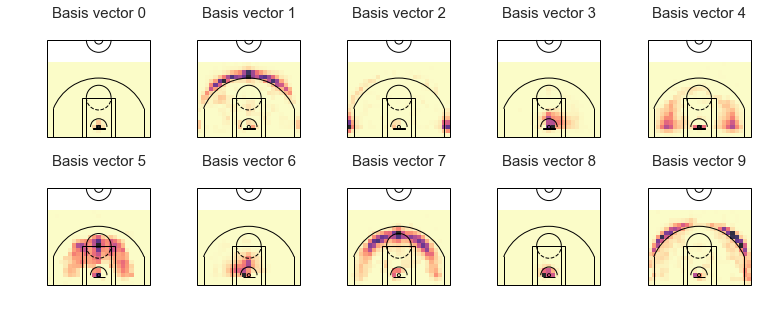

In [27]:
n_comp = 10
model = NMF(n_components=n_comp, init='nndsvda', max_iter=8000, tol=1e-7,
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W_10 = model.fit_transform(LL)
H_10 = model.components_   

plot_featuresH(H_10, n_comp, xedges, yedges, bins, figsize=(13,5))

Here we have (from the offensive player's perspective):
* **Basis 0**: at basket
* **Basis 1**: straight-away 3s
* **Basis 2**: corner 3s
* **Basis 3**: left block
* **Basis 4**: baseline mid-range
* **Basis 5**: high-post
* **Basis 6**: right block
* **Basis 7**: long 2s
* **Basis 8**: inside
* **Basis 9**: wing 3s


For the rest of the LGCP+NMF models, I am going to stop naming these features, but if you are a basketball fan, see if you recognize those areas on the court!

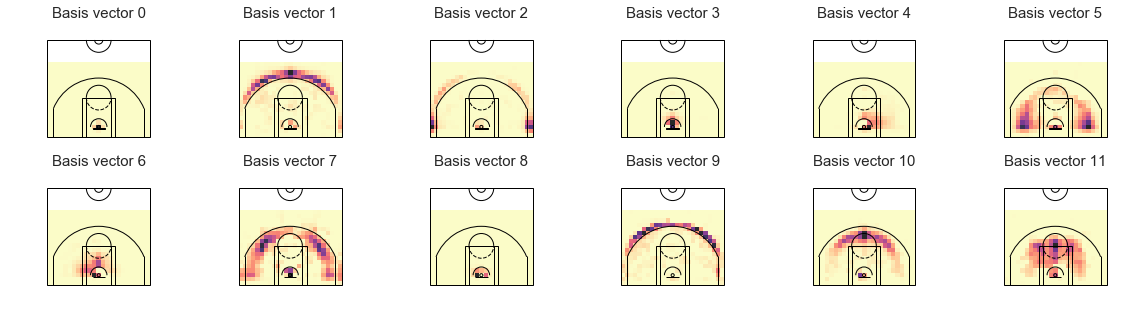

In [28]:
n_comp = 12
model = NMF(n_components=n_comp, init='nndsvda', max_iter=10000, tol=1e-6,
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W_12 = model.fit_transform(LL)
H_12 = model.components_   

plot_featuresH(H_12, n_comp, xedges, yedges, bins)

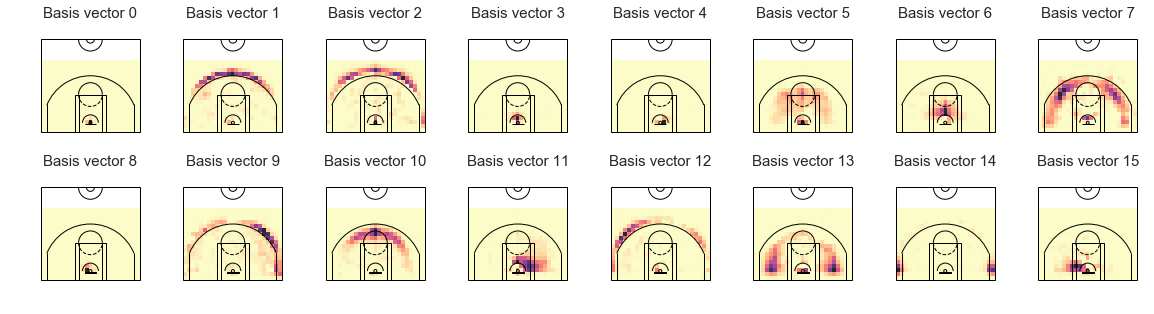

In [29]:
n_comp = 16
model = NMF(n_components=n_comp, init='nndsvda', max_iter=15000, tol=5e-6,
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W_16 = model.fit_transform(LL)
H_16 = model.components_   

plot_featuresH(H_16, n_comp, xedges, yedges, bins)

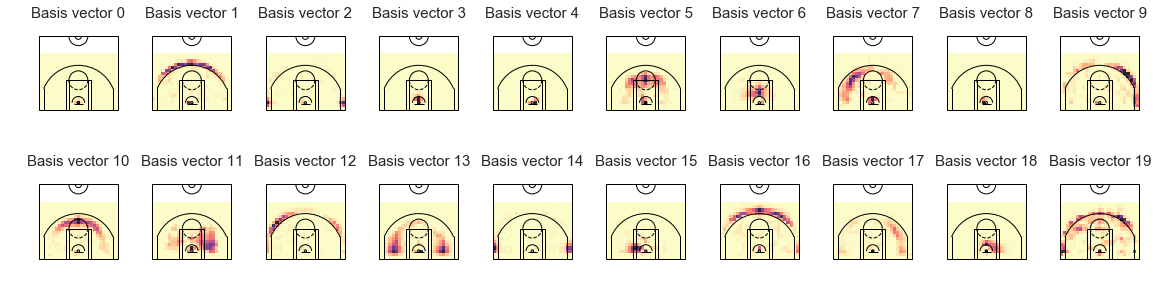

In [30]:
n_comp = 20
model = NMF(n_components=n_comp, init='nndsvda', max_iter=15000, tol=5e-6,
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W_20 = model.fit_transform(LL)
H_20 = model.components_   

plot_featuresH(H_20, n_comp, xedges, yedges, bins)

## Normalizing the weights and features

The weird thing is that each basis vector is not normalized. Since each basis is a spatial probability distribution, they should sum to one.

In [31]:
n_comp = 16
print([np.sum(H_16[i,:]) for i in range(n_comp)])

[5.4099867302199938, 4.9209302578869085, 4.2094718823841646, 4.950976041188528, 3.1877887341698941, 5.6473408059638821, 4.4470498350329706, 4.6661755789867447, 4.3154596136593932, 5.1310038352101337, 4.6666557772545811, 3.8666824997716112, 5.5624327843920227, 4.6190851710856826, 4.8318164992651482, 3.3882886036070263]


And the sum of the weights for each player also do not add to one.

In [32]:
print([np.sum(W_16[i,:]) for i in range(10)])

[0.20739329375289942, 0.20877343173330001, 0.21482268954660527, 0.21565167126995732, 0.22128088525409706, 0.21816034955246835, 0.22904692186596165, 0.21766871913676439, 0.21311767457110842, 0.21120833337379991]


We can easily fix this by normalizing each basis and adjusting the weights to account for this normalization.

Now the basis vectors are normalized and the weights sum to (approximately) one.

In [33]:
def normalize_W_and_H(W, H, n_comp):
    W_norm = np.copy(W)
    H_norm = np.copy(H)
    for i in range(n_comp):
        temp = np.sum(H[i,:])
        W_norm[:,i] *= temp
        H_norm[i,:] *= 1./temp
    return W_norm, H_norm

W_4_norm, H_4_norm = normalize_W_and_H(W_4, H_4, 4)
W_6_norm, H_6_norm = normalize_W_and_H(W_6, H_6, 6)
W_10_norm, H_10_norm = normalize_W_and_H(W_10, H_10, 10)
W_12_norm, H_12_norm = normalize_W_and_H(W_12, H_12, 12)
W_16_norm, H_16_norm = normalize_W_and_H(W_16, H_16, 16)
W_20_norm, H_20_norm = normalize_W_and_H(W_20, H_20, 20)

print('Sum of weights for first 10 players :')
[np.sum(W_16_norm[i,:]) for i in range(10)]

Sum of weights for first 10 players :


[1.0000023515069203,
 0.99999555941259355,
 1.0000028528196512,
 0.99998674467296311,
 1.0000128978210263,
 1.000024725287779,
 1.0000188123329992,
 1.0000073512896599,
 0.99998602245339319,
 1.0000012658238795]

And we can save these results in an .npz file.

In [34]:
np.savez('NMF_results.npz', 
         W_4_norm = W_4_norm, H_4_norm = H_4_norm, 
         W_6_norm = W_6_norm, H_6_norm = H_6_norm,
         W_10_norm = W_10_norm, H_10_norm = H_10_norm, 
         W_12_norm = W_12_norm, H_12_norm = H_12_norm,
         W_16_norm = W_16_norm, H_16_norm = H_16_norm,
         W_20_norm = W_20_norm, H_20_norm = H_20_norm,
        )

## Comparing LGCP and LGCP+NMF models. Which is more predictive?

As we get to 20 features, it seems like some of the Basis vectors are getting pretty noisy an weird, so we will stop at 20 features.

Let's see what the estimated shot distriubtion looks like after NMF (LGCP+NMF model). As a reminder, NMF has decomposed every player's shot distriubtion (from the LGCP model) into a weighted average of the features that are shared amongst all players. This means that all players' shooting habits are made of the same features but in different amounts. 

That allows the estimated distributions to be smoothed out because, in a sense, it also accounts for the shooting habits of that player's peers that shoot from that general area too. This is why NMF is used in signal prossessing to remove noise from pictures.

Let's look at what happens to Stephen Curry's shot distriubtion looks like now.

---------------------------------------
Note: We will now use pre-computed solutions to the NMFs that were computed with a lower tolerance and saved as a .npz file.

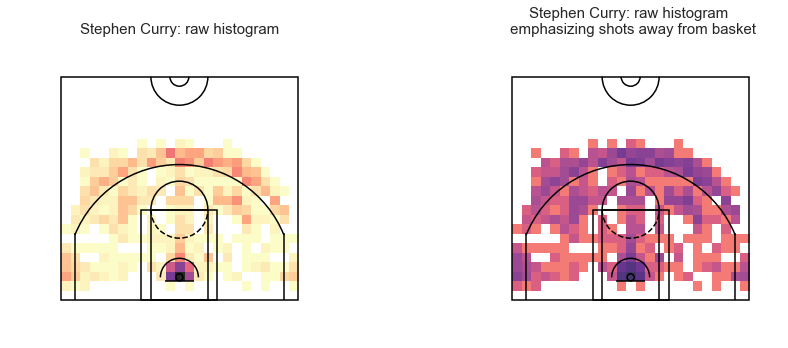

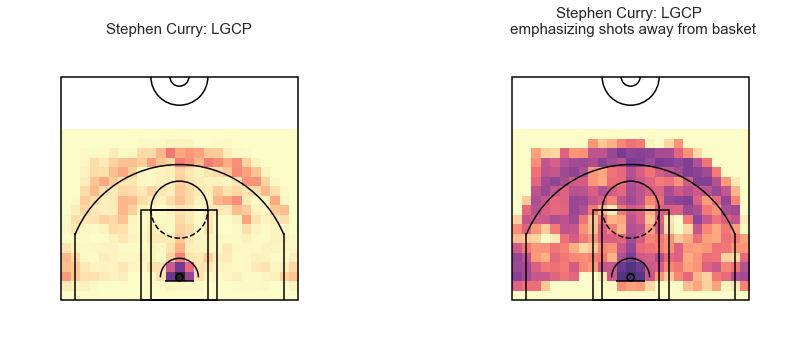

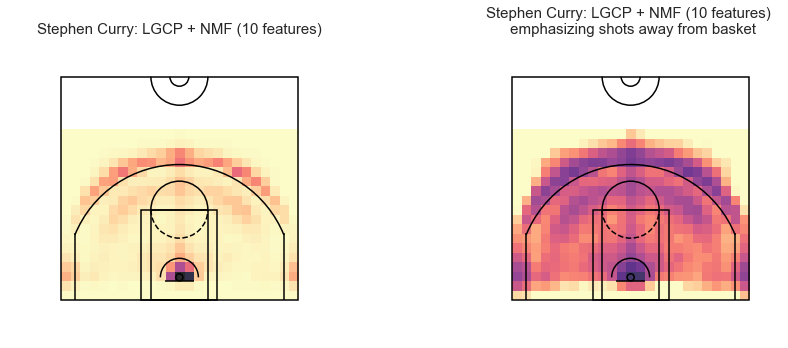

In [35]:
player = 'Stephen Curry'
player_index = top_players_nameList.index(player)
num_features = 10
####################################################
Xn_v = player_shotHist_train[player]

npzfile = np.load('NMF_results_lowTol.npz')
norm_lambdaN_v_NMF = np.matmul(npzfile['W_%d_norm'%num_features] , npzfile['H_%d_norm'%num_features])[player_index,:]

histN_v = Xn_v/np.sum(Xn_v)
norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))

plot_player_x2(player, histN_v, add_title='raw histogram')
plot_player_x2(player, norm_lambdaN_v_smallPhi, add_title=r'LGCP')
plot_player_x2(player, norm_lambdaN_v_NMF, add_title=r'LGCP + NMF (%d features)'%num_features)

Awesome! We definitely can see that the **LGCP+NMF distribution looks pretty regular and smooth**. 

My gut would tell me that this smoother distribution is probably a better description of Curry's shot behavior. I mean, would you expect a player's shooting habits to vary eratically in space? Probably not.

-----

But it is interesting to not that the LGCP+NMF model seems to result in a pretty symmetric shot distribution, even if there is an spatial asymmetry in both the raw histogram and LGCP model. 
For example, the raw histogram and LGCP model seems to show that Curry prefers to shoot three point shots on the upper-right (his left) side of the three-point line. 
But that subtlety seems to get lost in the NMF.
That might be because other three-point shooters may have no preference or prefer to shoot on the right, so their behavior gets accounted for when building features and leads to **relatively symmetric features**.

We will return to this issue in a bit.

------

But first, let's see if NMF has improved our ability to predict a player's shooting habits.
If the NMF has a higher likelihood score for observing the testing data, the NMF estimation ($[\mathbf{W} \mathbf{H}]_i$) of the $i$-th players shot distributions is a better predictor because it assumes that players are not *that* different from each other.

So let's see what happens when we compare likelihood scores.

In [36]:
def ln_factorial(n):
    temp = scipy.misc.factorial(n)
    return np.log(temp)

def ln_likelihood_givenLambda(lamdan_v, Xn_v):
    part1 = -lamdan_v
    part2 = Xn_v * np.log(lamdan_v)
    part3 = -ln_factorial(lamdan_v)
    return np.sum(part1 + part2 + part3)

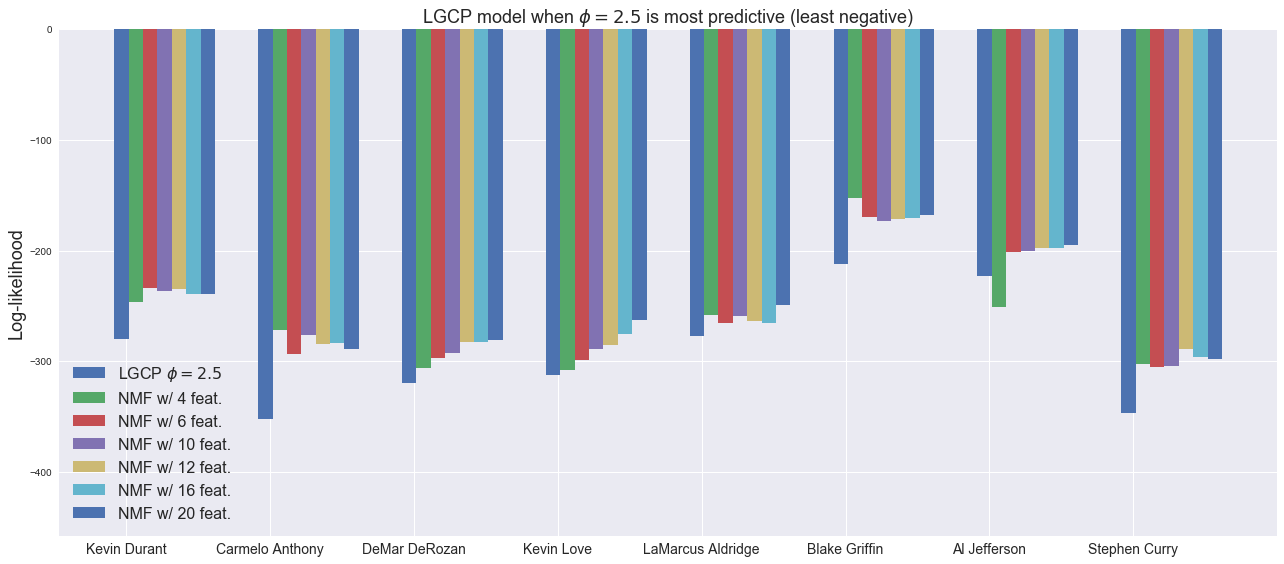

In [37]:
# Show the top 8 players
N = 8

npzfile = np.load('NMF_results_lowTol.npz')

LGCP_smallPhi_vec = []
NMF_vec = {}
for j in [4, 6, 10, 12, 16, 20]:
    NMF_vec[j] = []
for i in range(N):
    player = top_players_nameList[i]
    Xn_v = player_shotHist_test[player]
    num_shots = np.sum(Xn_v)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~
    norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))
    ln_likelihood_LGCP_smallPhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_smallPhi, Xn_v)
    LGCP_smallPhi_vec.append(ln_likelihood_LGCP_smallPhi)
    
    norm_lambdaN_v_NMF = {}
    ln_likelihood_NMF = {}
    for j in [4, 6, 10, 12, 16, 20]:
        norm_lambdaN_v_NMF[j] = np.matmul(npzfile['W_%d_norm'%j] , npzfile['H_%d_norm'%j])[i,:]
        ln_likelihood_NMF[j] = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_NMF[j], Xn_v)
        NMF_vec[j].append(ln_likelihood_NMF[j])

    
ind = 10*np.arange(N)  # the x locations for the groups
width = 1.       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18,8)

rects1 = ax.bar(ind, LGCP_smallPhi_vec, width)
rects = {}
temp = width
for key in [4, 6, 10, 12, 16, 20]:
    rects[key] = ax.bar(ind + temp, NMF_vec[key], width)
    temp = temp + width


# add some text for labels, title and axes ticks
ax.set_ylim(bottom = 1.3*min(LGCP_smallPhi_vec))
ax.set_ylabel('Log-likelihood', fontsize=18)
ax.set_title('LGCP model when $\phi=2.5$ is most predictive (least negative)', fontsize=18)
ax.set_xticks(ind + width / 3)
ax.set_xticklabels(top_players_nameList[:N], fontsize=14)

ax.legend((rects1[0], rects[4][0], rects[6][0], rects[10][0], rects[12][0], rects[16][0], rects[20][0]), 
          (r'LGCP $\phi=2.5$', 'NMF w/ 4 feat.', 'NMF w/ 6 feat.', 'NMF w/ 10 feat.', 'NMF w/ 12 feat.', 'NMF w/ 16 feat.', 'NMF w/ 20 feat.'), fontsize=16)

plt.tight_layout()
plt.show()

It looks like it is not as clear which model is more predictive, but in general NMF seems to remove some noise still in the LGCP model.

With one exception (i.e. Al Jefferson), LGCP+NMF models are more likely to give the testing data results.
For some players (e.g. Kevin Durant, Carmelo Anthony, and Stephen Curry), the improvement is pretty drastic.

Let's double check what it looks like for some players who shot a lot less.

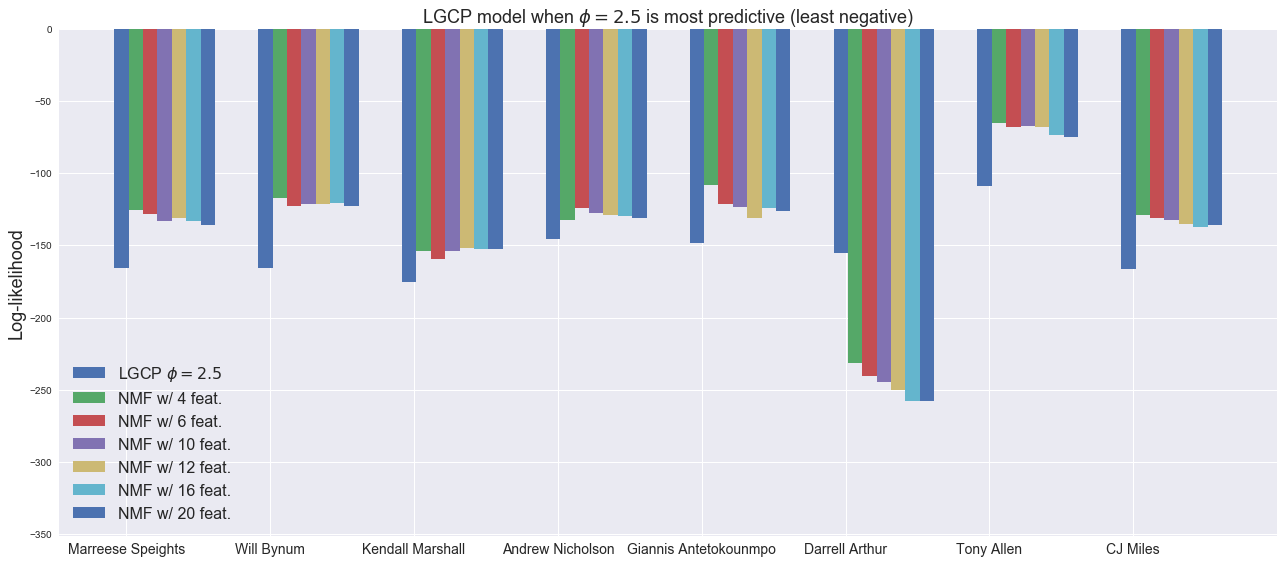

In [38]:
# Show the these players
player_index = np.arange(200,208)

npzfile = np.load('NMF_results_lowTol.npz')

LGCP_smallPhi_vec = []
NMF_vec = {}
for j in [4, 6, 10, 12, 16, 20]:
    NMF_vec[j] = []
for i in player_index:
    player = top_players_nameList[i]
    Xn_v = player_shotHist_test[player]
    num_shots = np.sum(Xn_v)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~
    norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))
    ln_likelihood_LGCP_smallPhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_smallPhi, Xn_v)
    LGCP_smallPhi_vec.append(ln_likelihood_LGCP_smallPhi)
    
    norm_lambdaN_v_NMF = {}
    ln_likelihood_NMF = {}
    for j in [4, 6, 10, 12, 16, 20]:
        norm_lambdaN_v_NMF[j] = np.matmul(npzfile['W_%d_norm'%j] , npzfile['H_%d_norm'%j])[i,:]
        ln_likelihood_NMF[j] = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_NMF[j], Xn_v)
        NMF_vec[j].append(ln_likelihood_NMF[j])

    
ind = 10*np.arange(N)  # the x locations for the groups
width = 1.       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18,8)

rects1 = ax.bar(ind, LGCP_smallPhi_vec, width)
rects = {}
temp = width
for key in [4, 6, 10, 12, 16, 20]:
    rects[key] = ax.bar(ind + temp, NMF_vec[key], width)
    temp = temp + width


# add some text for labels, title and axes ticks
ax.set_ylim(bottom = 2*min(LGCP_smallPhi_vec))
ax.set_ylabel('Log-likelihood', fontsize=18)
ax.set_title('LGCP model when $\phi=2.5$ is most predictive (least negative)', fontsize=18)
ax.set_xticks(ind + width / 3)
ax.set_xticklabels(top_players_nameList[player_index[0]:player_index[-1]+1], fontsize=14)

ax.legend((rects1[0], rects[4][0], rects[6][0], rects[10][0], rects[12][0], rects[16][0], rects[20][0]), 
          (r'LGCP $\phi=2.5$', 'NMF w/ 4 feat.', 'NMF w/ 6 feat.', 'NMF w/ 10 feat.', 'NMF w/ 12 feat.', 'NMF w/ 16 feat.', 'NMF w/ 20 feat.'), fontsize=16)

plt.tight_layout()
plt.show()

Uh oh. It seems like *sometimes* (e.g. Darrell Arthur) NMF results in *less* predictive models.

These exceptions do appear to be outliers, but I think it is interesting to try to understand why. 
Let's start by looking at Darrell Arthur's predicted shot distributions.

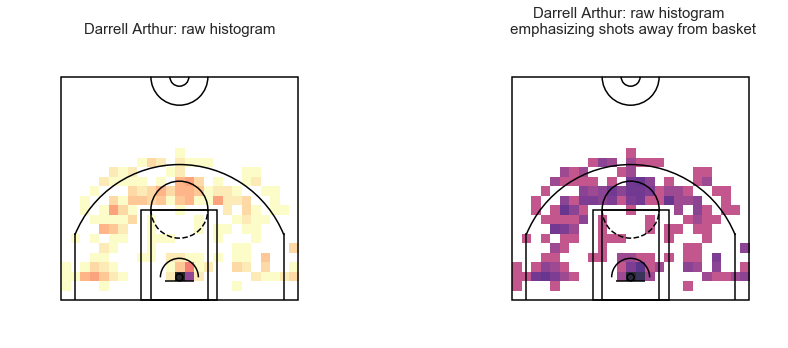

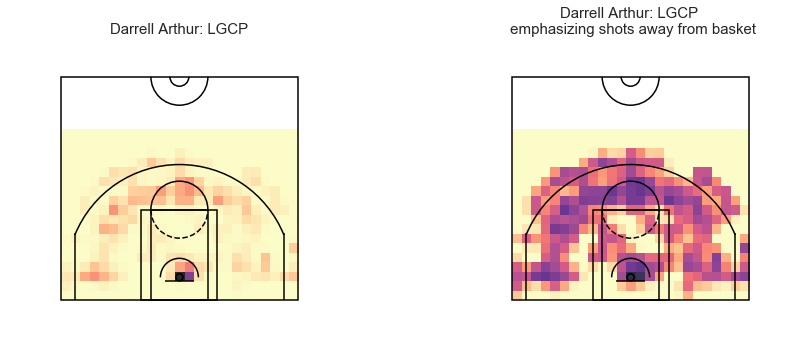

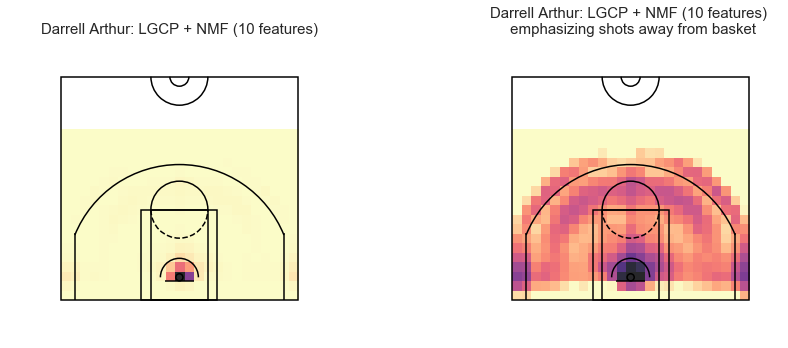

In [39]:
player = 'Darrell Arthur'
player_index = top_players_nameList.index(player)
num_features = 10
####################################################
Xn_v = player_shotHist_train[player]

npzfile = np.load('NMF_results_lowTol.npz')
norm_lambdaN_v_NMF = np.matmul(npzfile['W_%d_norm'%num_features] , npzfile['H_%d_norm'%num_features])[player_index,:]

histN_v = Xn_v/np.sum(Xn_v)
norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))

plot_player_x2(player, histN_v, add_title='raw histogram')
plot_player_x2(player, norm_lambdaN_v_smallPhi, add_title=r'LGCP')
plot_player_x2(player, norm_lambdaN_v_NMF, add_title=r'LGCP + NMF (%d features)'%num_features)

Remember when we were worried about the relatively symmetric features created by NMF? Yep, you guessed it. It looks like it really hurt us this time.

Unlike Stephen Curry's slight side preference, Darrell Arthur *really* favors the left (his right) side of the court. Losing that information really hurts the LGCP+NMF models' ability to predict his shooting habits.

I am not sure what is the best way to fix this issue. I could add more features. 
We can see that when we have 20 features, there are some asymmetric features, but more features increases the complexity of the model more, making it more difficult to interpret the large number of feature weights.
So we have a common trade-off between model complexity and accuracy.

Other players where LGCP outpreforms LGCP+NMF do not have the asymmetry problem, but seem to have hot spots that are in a slightly different place than most other players (i.e. the features from NMF). This might be an interesting way to identify outlier players (or players with unique shooting habits), but it is a bit of a bummer that we cannot using this smoothing procedure to improve our predictions.

For now I will stick with 10 features NMF because it seems to have a pretty good likelihood score for almost all players and has a reasonable level of complexity.

In [53]:
npzfile = np.load('NMF_results_lowTol.npz')

players_NMF_bad = []

for i, player in enumerate(top_players_nameList):
    Xn_v = player_shotHist_test[player]
    num_shots = np.sum(Xn_v)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~
    norm_lambdaN_v_smallPhi = np.loadtxt('player2013_lambda_seed348098/norm_lambda_%s.txt'%(player))
    ln_likelihood_LGCP_smallPhi = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_smallPhi, Xn_v)
    
    j=10
    norm_lambdaN_v_NMF = np.matmul(npzfile['W_%d_norm'%j] , npzfile['H_%d_norm'%j])[i,:]
    ln_likelihood_NMF = ln_likelihood_givenLambda(num_shots*norm_lambdaN_v_NMF, Xn_v)
    
    if (ln_likelihood_LGCP_smallPhi > ln_likelihood_NMF):
        print(player)
        players_NMF_bad.append([i,player])

print('---------------------------------------------')
print('number of players where LGCP+NMF (10 factors) has lower log-likelihood than that of LGCP:  %d of %d players'%(len(players_NMF_bad), len(top_players_nameList)))

Kemba Walker
Evan Turner
Tony Parker
Nick Young
Tim Duncan
Chris Paul
Luol Deng
Khris Middleton
Paul Pierce
Patty Mills
Nikola Vucevic
Mo Williams
Marcus Morris
Kyle Singler
DeAndre Jordan
Norris Cole
Patrick Patterson
Darrell Arthur
Jordan Hamilton
Ryan Anderson
Kent Bazemore
Robert Sacre
Danny Granger
Dorell Wright
Mason Plumlee
Jermaine O'Neal
Andrew Bynum
---------------------------------------------
number of players where LGCP+NMF (10 factors) has lower log-likelihood than that of LGCP:  27 of 300 players


## Summary of results for all players

Now, I will show you the normalized weights of each basis vector for each player. You can see from the table how players differ from each other.

------------------------
Summary of the basis vectors:

We will rename the vectors according to their basketball terminology:
* **Basis 0**: at basket
* **Basis 1**: straight-away 3s
* **Basis 2**: corner 3s
* **Basis 3**: left block
* **Basis 4**: baseline mid-range
* **Basis 5**: high-post
* **Basis 6**: right block
* **Basis 7**: long 2s
* **Basis 8**: inside
* **Basis 9**: wing 3s

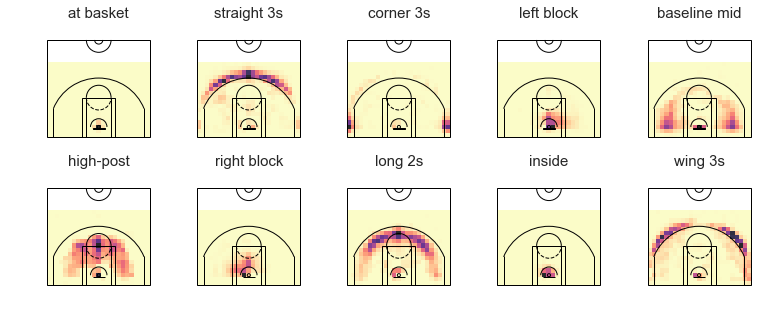

In [41]:
num_features = 10
npzfile = np.load('NMF_results_lowTol.npz')
column_names = ['at basket',
                'straight 3s',
                'corner 3s',
                'left block',
                'baseline mid',
                'high-post',
                'right block',
                'long 2s',
                'inside',
                'wing 3s'
               ]

df_Wnorm = pd.DataFrame(npzfile['W_%d_norm'%num_features], index=top_players_nameList, 
                        columns = column_names)
plot_featuresH(npzfile['H_%d_norm'%num_features], num_features, xedges, yedges, bins, figsize=(13,5),
               basis_names=column_names)

In [42]:
pd.options.display.float_format = '{:,.4f}'.format
df_Wnorm.describe(include='all')

,at basket,straight 3s,corner 3s,left block,baseline mid,high-post,right block,long 2s,inside,wing 3s
count,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000,300.0000
mean,0.1264,0.1098,0.0836,0.0875,0.0632,0.0745,0.0891,0.1020,0.1476,0.1162
std,0.1114,0.1081,0.0939,0.0922,0.0683,0.0783,0.0882,0.1013,0.1124,0.1168
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0453,0.0040,0.0063,0.0196,0.0087,0.0142,0.0265,0.0256,0.0687,0.0005
50%,0.0995,0.0962,0.0515,0.0603,0.0453,0.0500,0.0619,0.0772,0.1302,0.0869
75%,0.1676,0.1750,0.1379,0.1213,0.0922,0.1113,0.1300,0.1495,0.2056,0.1929
max,0.7537,0.5400,0.5020,0.5036,0.3887,0.6091,0.4848,0.6471,0.6879,0.5949


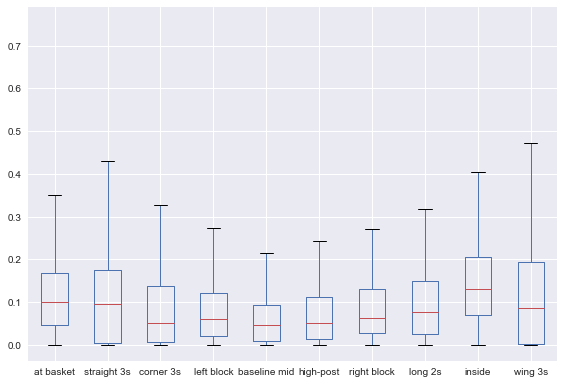

In [43]:
df_Wnorm.boxplot()
plt.tight_layout()
plt.show()

From this data, we can already start to see details about gloabal shooting habits.

Even though "at basket" and "inside" basis vectors pretty much only account for shots taken from a small fraction of court (about 6 to 9 of the 450 bins), almost all players shoot a decent fraction of their shots from there.
This is no suprise because players try to manufacture opportunities to shoot from there because those areas are generally the easiest places to score on the entire court.

On the other hand, we see a clear difference in shooting behavior 

In [44]:
def color_df_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for large weights , 
    black otherwise.
    """
    if (float(val) > 0.20):
        color = 'purple'
    elif (float(val) > 0.10):
        color = 'orangered'
    else: 
        color = 'black'
    return 'color: %s' % color

In [48]:
df_Wnorm_pretty = round(df_Wnorm, 4)
df_Wnorm_pretty[:100].style.applymap(color_df_red)

,at basket,straight 3s,corner 3s,left block,baseline mid,high-post,right block,long 2s,inside,wing 3s
Kevin Durant,0.1227,0.2325,0.0093,0.0912,0.0813,0.21,0.0618,0.0481,0.0593,0.0839
Carmelo Anthony,0.0444,0.1112,0.0016,0.0154,0.3062,0.115,0,0.0916,0.1262,0.1882
DeMar DeRozan,0.0243,0.0258,0.0817,0.0766,0.2026,0.1203,0.0585,0.239,0.1002,0.0709
Kevin Love,0.1155,0.2056,0,0.1492,0.0512,0.019,0.0817,0.0565,0.0974,0.2238
LaMarcus Aldridge,0.0748,0.0038,0.0008,0.2027,0.1615,0.1621,0,0.3383,0.0532,0.0028
Blake Griffin,0.1186,0.0139,0.0183,0.1398,0.0121,0.046,0.051,0.2874,0.313,0
Al Jefferson,0.1025,0.0019,0.0003,0.3074,0.151,0.1518,0.1293,0.0797,0.0763,0
Stephen Curry,0.029,0.3857,0.0596,0.0522,0.0043,0.053,0.0376,0.197,0.0912,0.0906
LeBron James,0.1898,0.1057,0.034,0.0845,0.0651,0.0599,0.003,0.0915,0.2253,0.1411
Paul George,0.0719,0.2449,0.0875,0.0211,0.1243,0.1651,0.0117,0.0653,0.1374,0.0708


In [46]:
top_players_nameList.index('James Harden')

18

The following data frame is the difference of that player's weights from that basis vector's median (not mean). This should give us a good idea if that player falls in the top/bottom 50% in a shot type category and by how much.

I chose to use the median because the distributions of weights are pretty skewed, so I felt that the mean is going to be too sensitive to outliers.

In [49]:
df_Wnorm_relative = round(df_Wnorm - df_Wnorm.describe(include='all').loc['50%'], 4)

df_Wnorm_relative[:100].style.bar(subset=df_Wnorm_relative.columns.values.tolist(), align='mid', color=['#d65f5f', '#5fba7d'])

Let's look at a few players to show what kind of information we can get from these set of tables.

Kevin Durant shoots 3s...
* but he shoots straight away 3s a lot more than his peers (well into the top 25%)
* doesn't shoot many corner 3s
* at right about the 50% from the wing

Both Stephen Curry, Damian Lilard, and James Harden shoot a *ton* of straight-away 3s (a lot more than any of the other top 20 players in shot attempts).
This makes sense because they are infamous for pulling up for a quick 3 from there after dribling down the court or off of a series of dribbling moves.

Al Jefferson prefers to work in the left block more. And that is exactly what his scouting report says before he was drafted in 2008. I guess not much has changed in 5 years.
> "Gets almost three quarters of his touches on the left block" - Source: http://www.draftexpress.com/profile/Al-Jefferson-2979/ ©DraftExpress 

John Wall is known for being a blur and scoring close to the basket, but he also shoots a lot of long 2s.

Dirk Nowitzki loves the baseline mid-ranger. That's one of his favorite spots to shoot his patented one-footed fadeaways.

--------------

This collection of data frames of the NMF weights provides a quantitative summary of each player's shooting habits.

Although the full LCGP+NMF distributions are great visuals for understanding each player's shooting habit, these data frames provide a more condensed quantitative comparison between mutliple players by reducing the number of variables from 450 (number of bins of the discrete distribution) to 10 (number of features).

We can also visually compare these weights using radar charts.

## Radar plots to visualize a player's shot profile

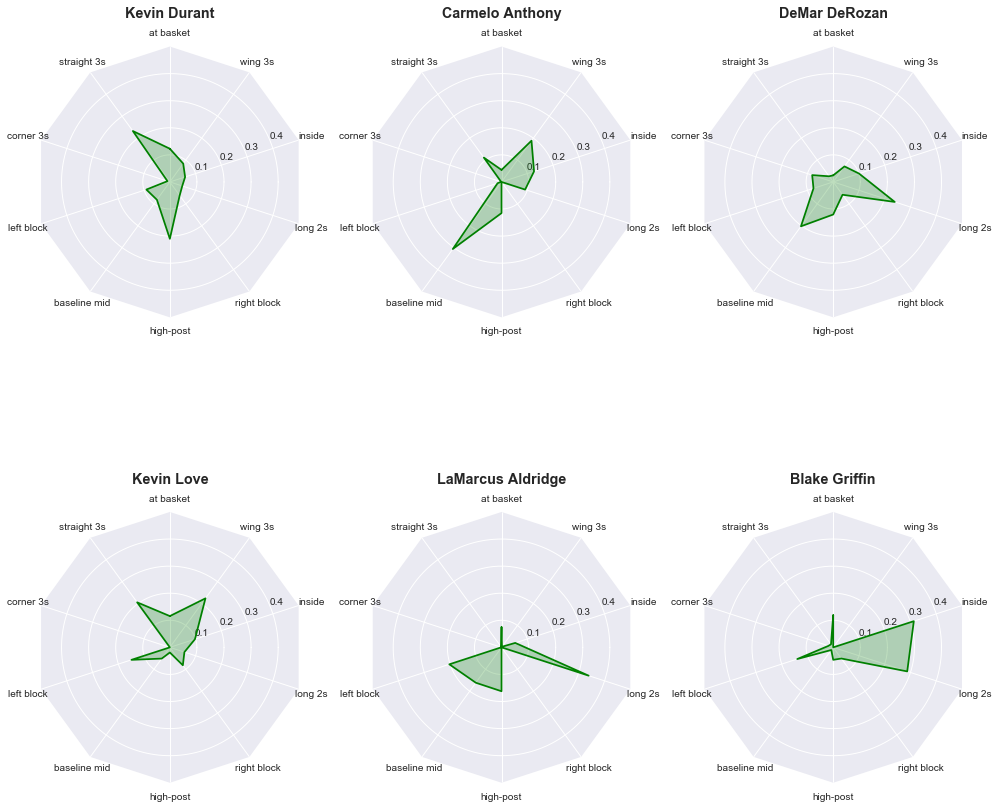

In [63]:
num_features = 10
theta = radar_plot.radar_factory(num_features, frame='polygon')
spoke_labels = df_Wnorm_pretty.columns.values.tolist()

fig, axes = plt.subplots(figsize=(14, 14), nrows=2, ncols=3,
                         subplot_kw=dict(projection='radar'))

for i, ax in enumerate(axes.flatten()):
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4])
    ax.set_ylim(0, 0.5)
    player_name = df_Wnorm.index.values[i]
    dat = np.array(df_Wnorm.loc[player_name], dtype='float')
    ax.set_title(player_name, weight='bold', size='large', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    color = 'green'
    ax.plot(theta, dat, color=color)
    ax.fill(theta, dat, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

plt.tight_layout()
plt.show()

# CLUSTERING PLAYERS based on of SHOT PROFILES

## Two-dimensional projections

OK. The prior tables has given us an idea of the distribution of NMF feature weights, but we might be able to better visualize them by looking at histograms and 2D scatter plots

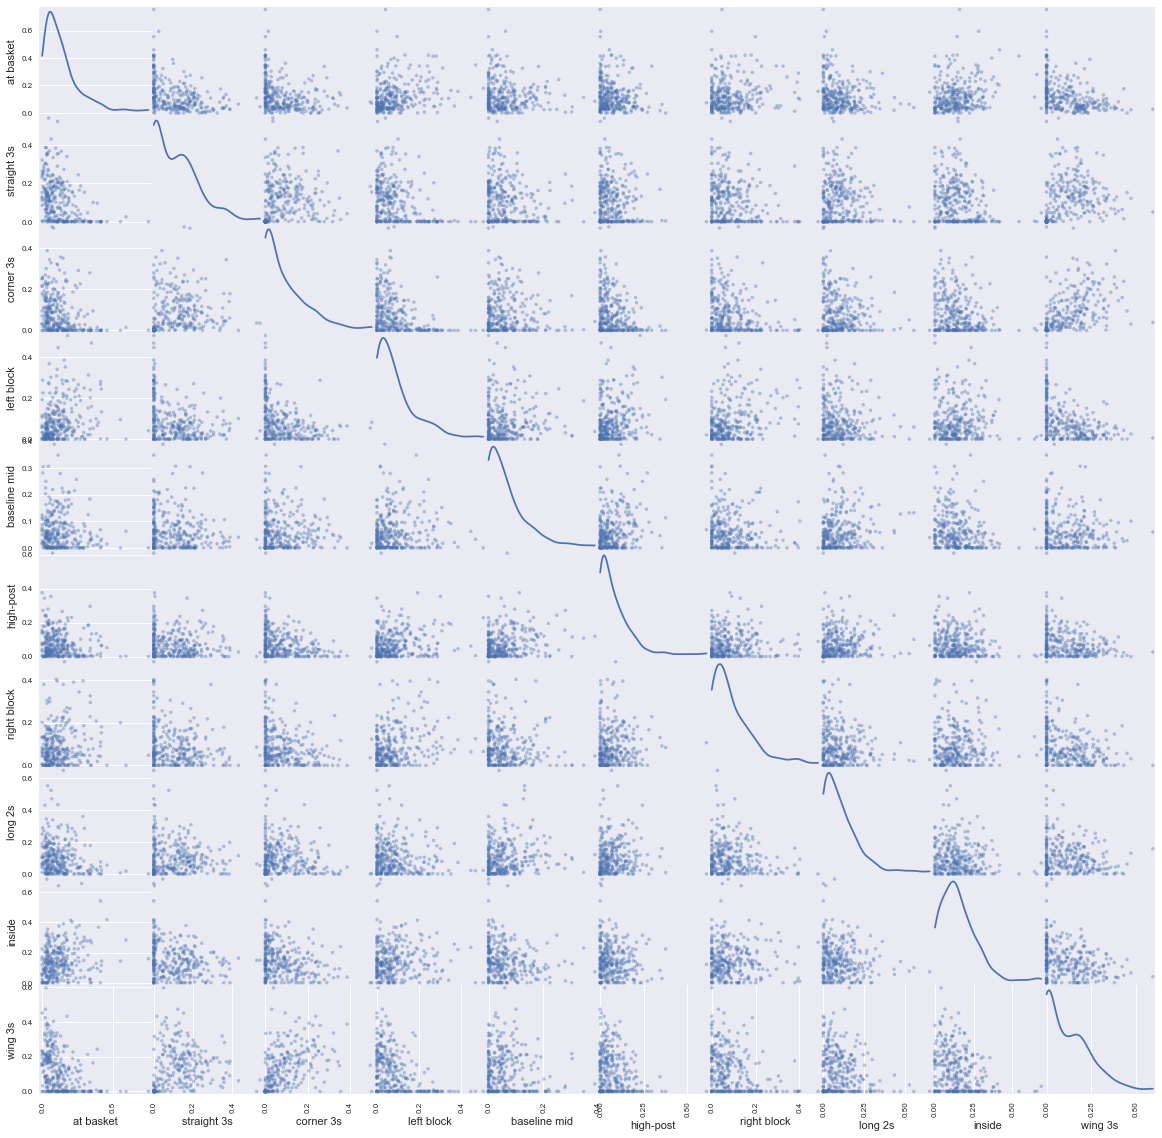

In [64]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_Wnorm, alpha=0.4, figsize=(20, 20), diagonal='kde')
plt.show()

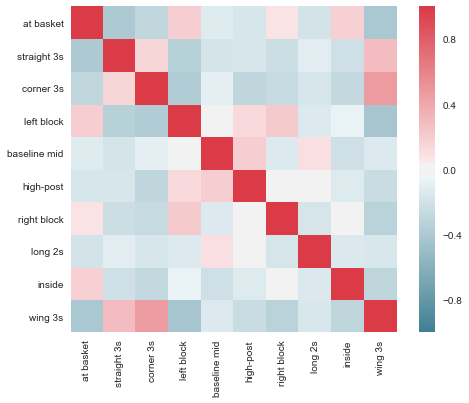

In [65]:
f, ax = plt.subplots(figsize=(8, 6))
corr = df_Wnorm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Differentiating players

I will use a custom distance metric: the Jensen–Shannon (JS) divergence. The JS divergence is a symmetrized version of the Kullback–Leibler (KL) divergence. 

The JS divergence compares two distributions and finds out how similar they are. If the JS divergence is 0, then the two distributions are identical. If the JS divergence is 1, then the two distributions behave in such a different manner that the likelihood that the first distribution describes the second approaches zero.

In [66]:
def divergence_kl(p, q):
    return np.sum(p * np.log(p/q))

def divergence_js(p,q):
    m = 0.5 * (p + q)
    return 0.5 * (divergence_kl(p, m) + divergence_kl(q, m))

def calc_divergenceJS_vec(LL):
    num_players = LL.shape[0]
    num_bins = LL.shape[1]
    divergence_vec = np.zeros(int(scipy.misc.comb(num_players,2)))
    LL_i = np.zeros(num_bins)
    LL_j = np.zeros(num_bins)
    ii = 0
    for i in np.arange(0, num_players):
        LL_i[:] = LL[i,:]
        for j in np.arange(i+1, num_players):
            LL_j[:] = LL[j,:]
            divergence_vec[ii] = divergence_js(LL_i, LL_j)
            ii = ii + 1
    return divergence_vec

Let's check if this works

In [67]:
p = np.array(LL[df_Wnorm.index.values == 'DeAndre Jordan',:], dtype='float')
q = np.array(LL[df_Wnorm.index.values == 'Andre Drummond'], dtype='float')
divergence_js(p,q)

0.068999034655577357

## Hierarchical clustering of the top 100 players

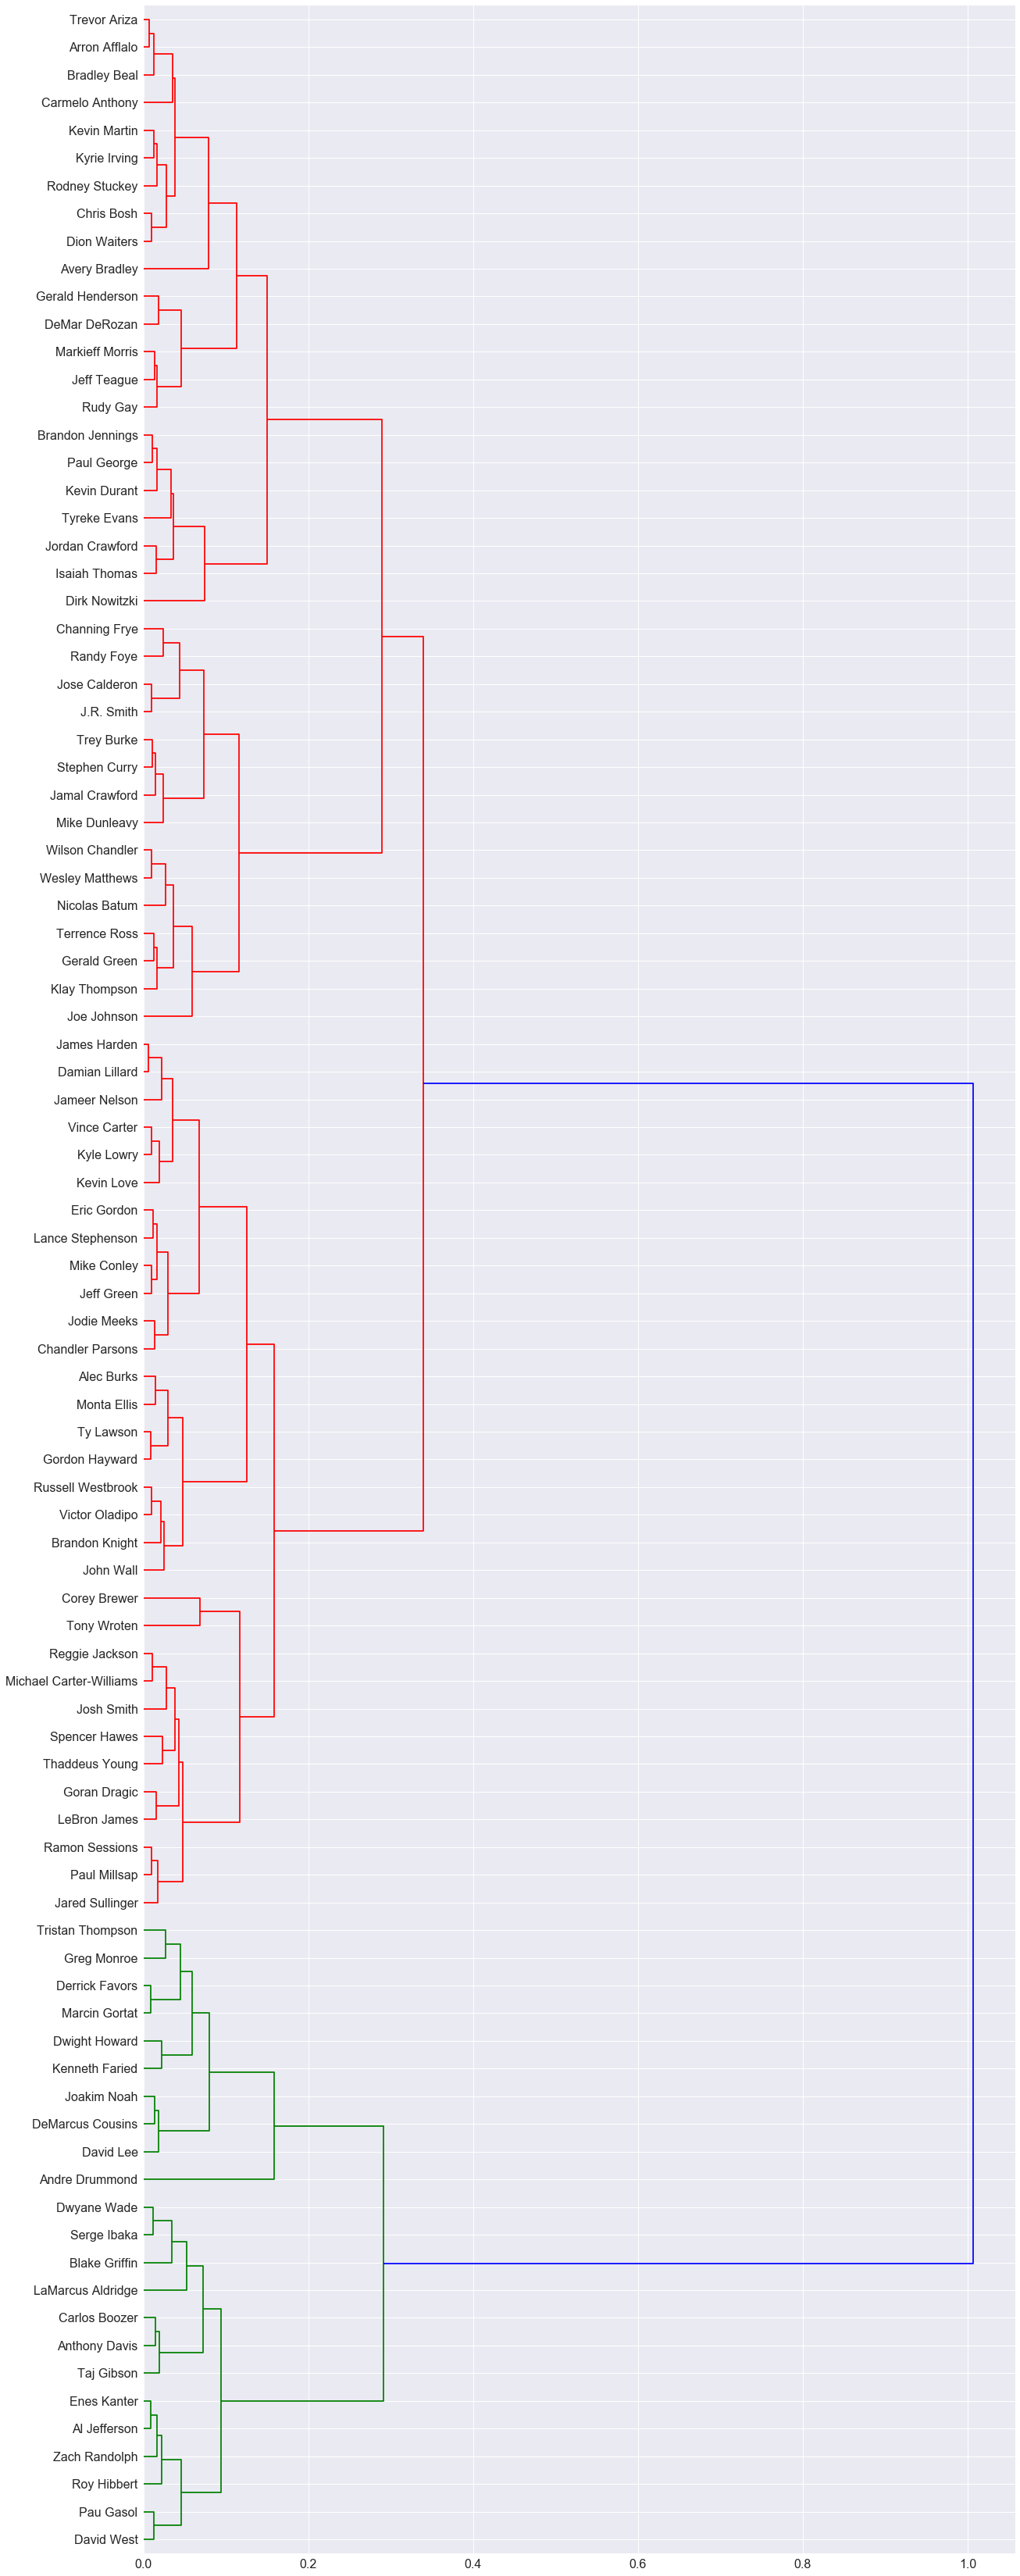

In [84]:
num_features = 10
number_of_players = 100

npzfile = np.load('NMF_results_lowTol.npz')
LL_NMF = np.matmul(npzfile['W_%d_norm'%num_features] , npzfile['H_%d_norm'%num_features])[:number_of_players,:]

players_NMF_bad_index = np.array([i for i, _ in players_NMF_bad])
players_NMF_bad_index = players_NMF_bad_index[players_NMF_bad_index < number_of_players]
LL_NMF_good = np.delete(LL_NMF, players_NMF_bad_index, axis=0)
player_names = np.array(top_players_nameList[:number_of_players])
player_names = np.delete(player_names, players_NMF_bad_index)

divergenceJS_vec = calc_divergenceJS_vec(LL_NMF_good)

plt.figure(figsize=(20,60))
plt.rcParams['xtick.labelsize'] = 16
Z = scipy.cluster.hierarchy.linkage(divergenceJS_vec, 'ward')
dn = scipy.cluster.hierarchy.dendrogram(Z, orientation='right', 
                                        labels=player_names, leaf_font_size=16)
plt.show()

In [80]:
np.shape(divergenceJS_vec)

(4186,)

In [ ]:
from pandas.plotting import parallel_coordinates
